# Deep Learning Project

In [ ]:
# import data
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/dagnelies/deepfake-faces/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: zhuoyanliu666
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dagnelies/deepfake-faces


100%|██████████| 433M/433M [00:27<00:00, 16.7MB/s]


# EDA

In [ ]:
# import packages
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
import seaborn as sns

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

In [ ]:
deepfake = pd.read_csv('/content/deepfake-faces/metadata.csv')

In [ ]:
# First few rows of the dataset
deepfake.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [ ]:
deepfake.shape

(95634, 5)

In [ ]:
# Count of 'FAKE' labels
fake_count = (deepfake['label'] == 'FAKE').sum()

# Count of 'REAL' labels
real_count = (deepfake['label'] == 'REAL').sum()

fake_count, real_count

(79341, 16293)

### Key Takeaway here: the dataset is highly imbalanced so upsampling/ downsampling or SMOTE is needed

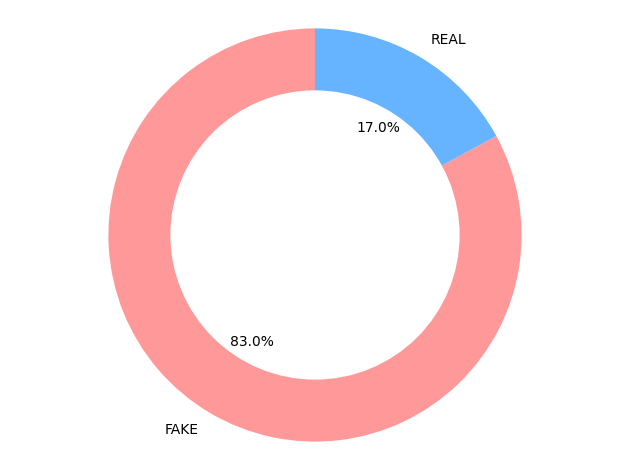

In [ ]:
#data distribution fake vs real in terms of percentage

total = fake_count + real_count
percentages = [fake_count / total, real_count / total]
labels = ['FAKE', 'REAL']
colors = ['#ff9999','#66b3ff']

# Creating the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(percentages, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# Display basic information
print("Dataset Info:")
print(deepfake.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95634 entries, 0 to 95633
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   videoname        95634 non-null  object
 1   original_width   95634 non-null  int64 
 2   original_height  95634 non-null  int64 
 3   label            95634 non-null  object
 4   original         79341 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB
None


In [ ]:
# Descriptive statistics
print("\nDescriptive Statistics:")
print(deepfake.describe())


Descriptive Statistics:
       original_width  original_height
count    95634.000000     95634.000000
mean       164.611174       164.565374
std         60.002852        60.011802
min         36.000000        36.000000
25%        108.000000       107.000000
50%        155.000000       155.000000
75%        223.000000       223.000000
max        665.000000       666.000000


In [ ]:
# Check for null values
print("\nNull Value Check:")
print(deepfake.isnull().sum())


Null Value Check:
videoname              0
original_width         0
original_height        0
label                  0
original           16293
dtype: int64


In [ ]:
print("\nDuplicated Value Check:")
print(deepfake.duplicated().sum())


Duplicated Value Check:
0


In [ ]:
# Label distribution
print("\nLabel Distribution:")
print(deepfake['label'].value_counts())


Label Distribution:
label
FAKE    79341
REAL    16293
Name: count, dtype: int64


In [ ]:
# Identify columns by data type
object_columns = deepfake.select_dtypes(include=['object']).columns
print("Object type columns:")
print(object_columns)

numerical_columns = deepfake.select_dtypes(include=['int64', 'float64']).columns
print("\nNumerical type columns:")
print(numerical_columns)

Object type columns:
Index(['videoname', 'label', 'original'], dtype='object')

Numerical type columns:
Index(['original_width', 'original_height'], dtype='object')


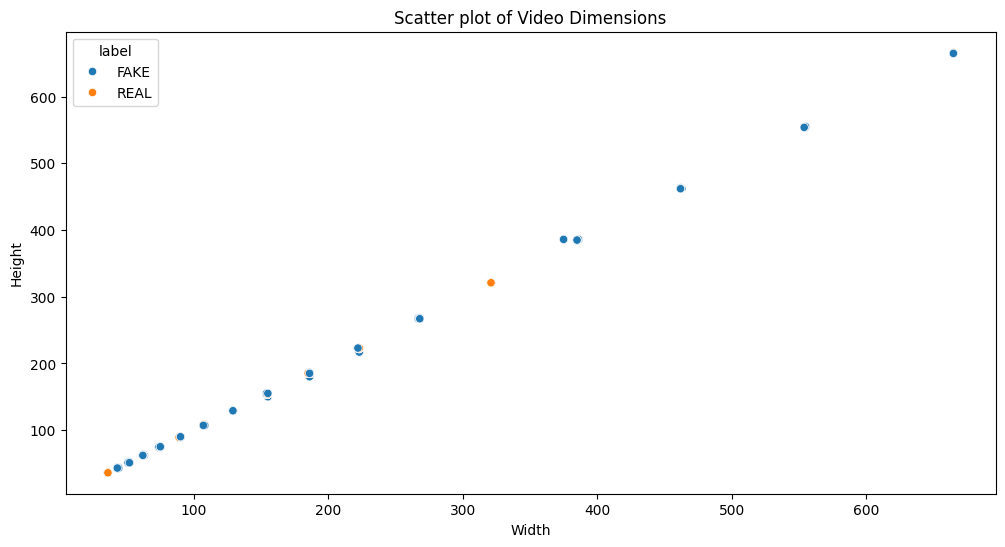

In [ ]:
# Visualization of video dimensions
plt.figure(figsize=(12, 6))
sns.scatterplot(x='original_width', y='original_height', hue='label', data=deepfake)
plt.title('Scatter plot of Video Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

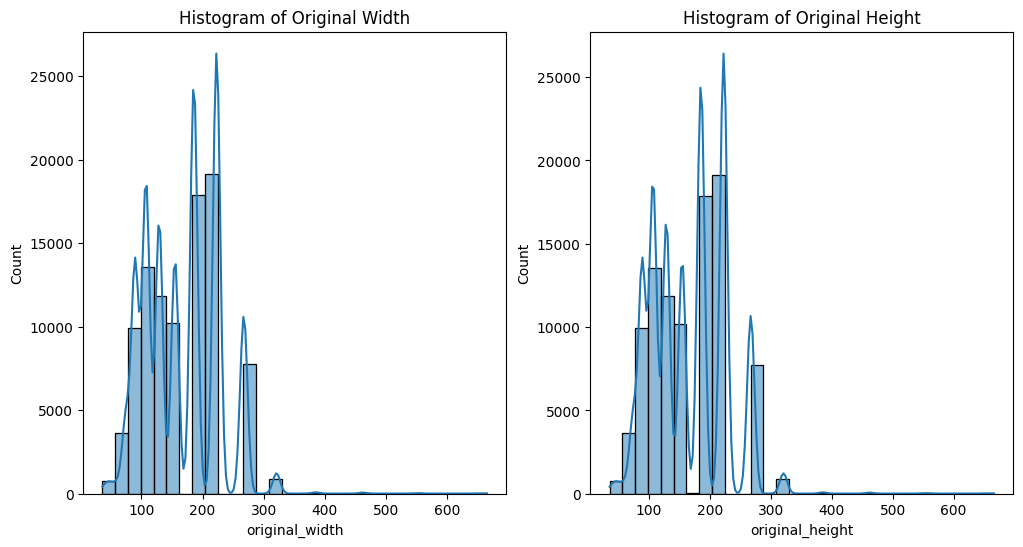

In [ ]:
# Histograms of dimensions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(deepfake['original_width'], kde=True, bins=30)
plt.title('Histogram of Original Width')

plt.subplot(1, 2, 2)
sns.histplot(deepfake['original_height'], kde=True, bins=30)
plt.title('Histogram of Original Height')
plt.show()

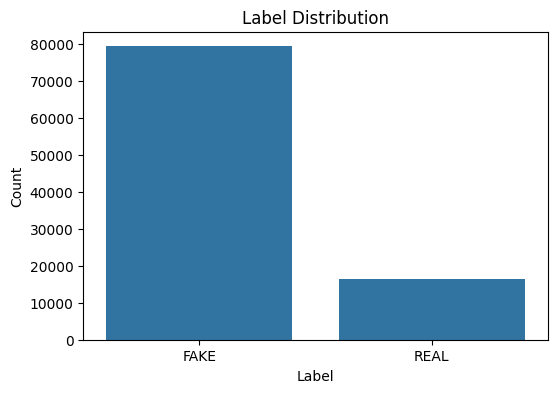

In [ ]:
# Bar chart for label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=deepfake)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

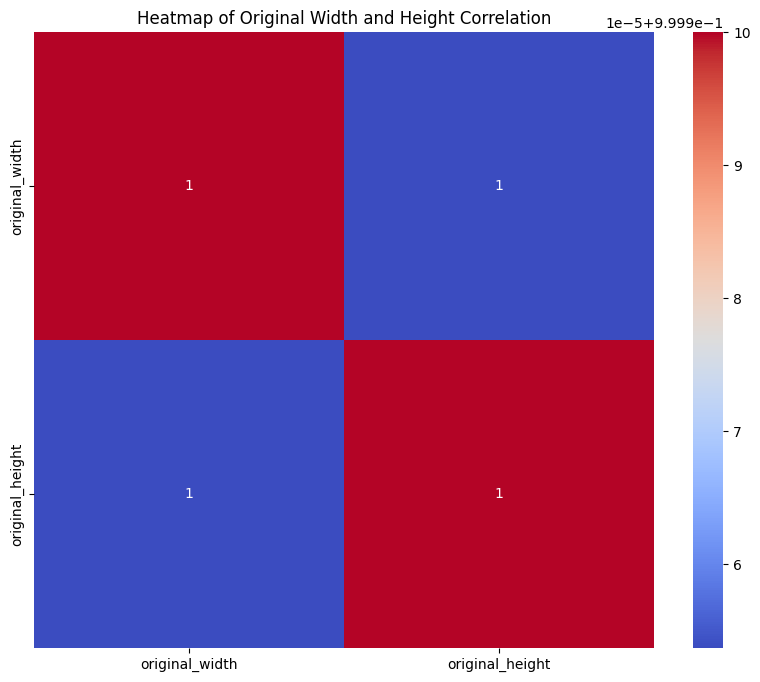

In [ ]:
#heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(deepfake[['original_width', 'original_height']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Original Width and Height Correlation')
plt.show()

### Takeaway:
- Generally both 'FAKE' and 'REAL' distributions span a similar range of widths and lengths, suggesting that the sizes of images used in both categories are quite comparable.
- However, it seems that real image has higher data density between 100 and 150 compared to the fake ones. This suggests that 'REAL' images tend to cluster around a more common width, whereas 'FAKE' images are more spread out.



<ipython-input-18-31267ebe1ff9>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




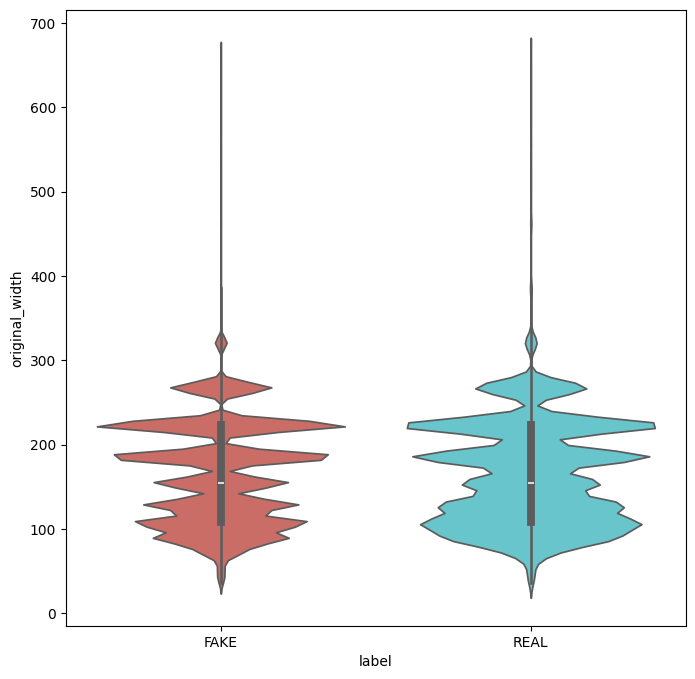

<ipython-input-18-31267ebe1ff9>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




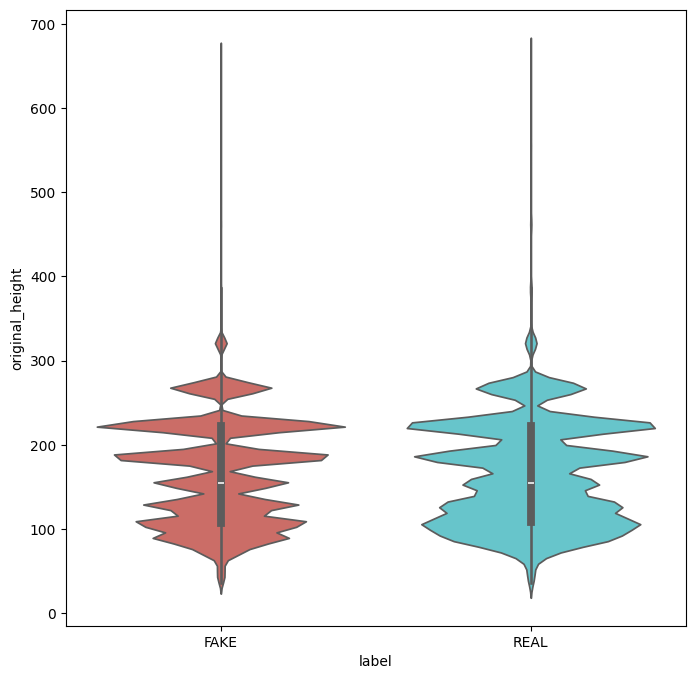

In [ ]:
categorical = ['label']
numerical_columns = ['original_width', 'original_height']

for i in categorical:
    for j in numerical_columns:
        plt.figure(figsize=(8,8))
        sns.violinplot(x = deepfake[i], y = deepfake[j], data = deepfake, palette = 'hls')
        plt.show()

### Select and display the first 9 images

/content/deepfake-faces/faces_224/aaagqkcdis.jpg
/content/deepfake-faces/faces_224/aaaoqepxnf.jpg
/content/deepfake-faces/faces_224/aaavbjopeq.jpg
/content/deepfake-faces/faces_224/aaavflklag.jpg
/content/deepfake-faces/faces_224/aabdnomlru.jpg
/content/deepfake-faces/faces_224/aabdogagch.jpg
/content/deepfake-faces/faces_224/aabgnwnqba.jpg
/content/deepfake-faces/faces_224/aabjfjbpir.jpg
/content/deepfake-faces/faces_224/aabkwhhgwv.jpg


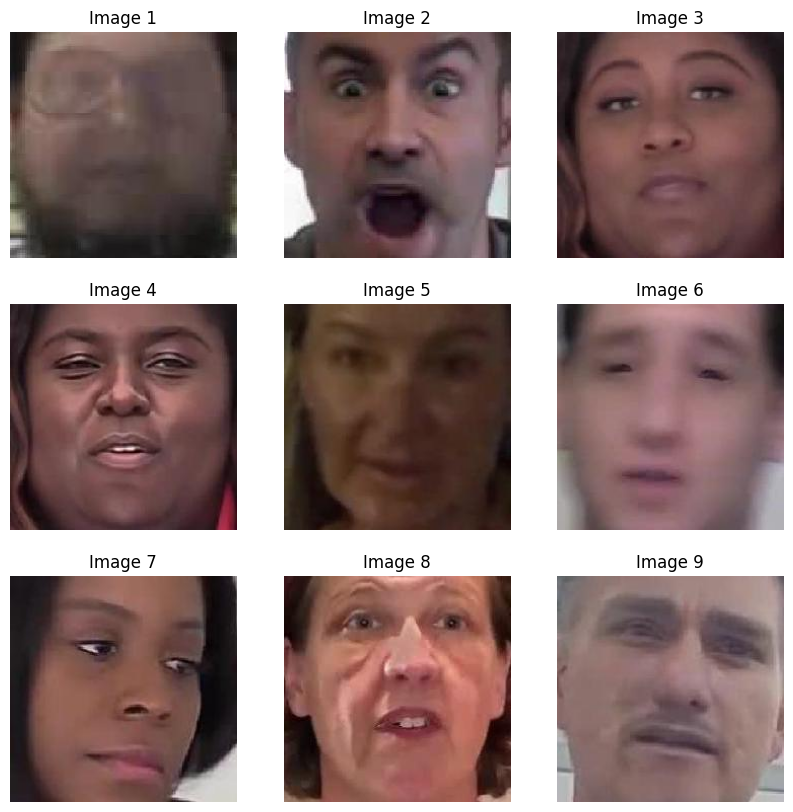

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

image_path = '/content/deepfake-faces/faces_224/'

# Ensure the directory exists and list all files
if os.path.exists(image_path):
    image_files = os.listdir(image_path)
    image_files.sort()

    # Select the first 9 images
    selected_images = image_files[:9]

    plt.figure(figsize=(10, 10))

    # Loop through the selected images, load them, and display
    for index, image_file in enumerate(selected_images):
        full_image_path = os.path.join(image_path, image_file)
        image = cv2.imread(full_image_path)

        if image is not None:
            print(full_image_path)
            # Convert from BGR to RGB format before displaying
            plt.subplot(3, 3, index + 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f'Image {index + 1}')
            plt.axis('off')
        else:
            print(f"Failed to load image: {full_image_path}")

    plt.show()
else:
    print(f"Directory not found: {image_path}")

### Guess which of these 9 pictures are fake

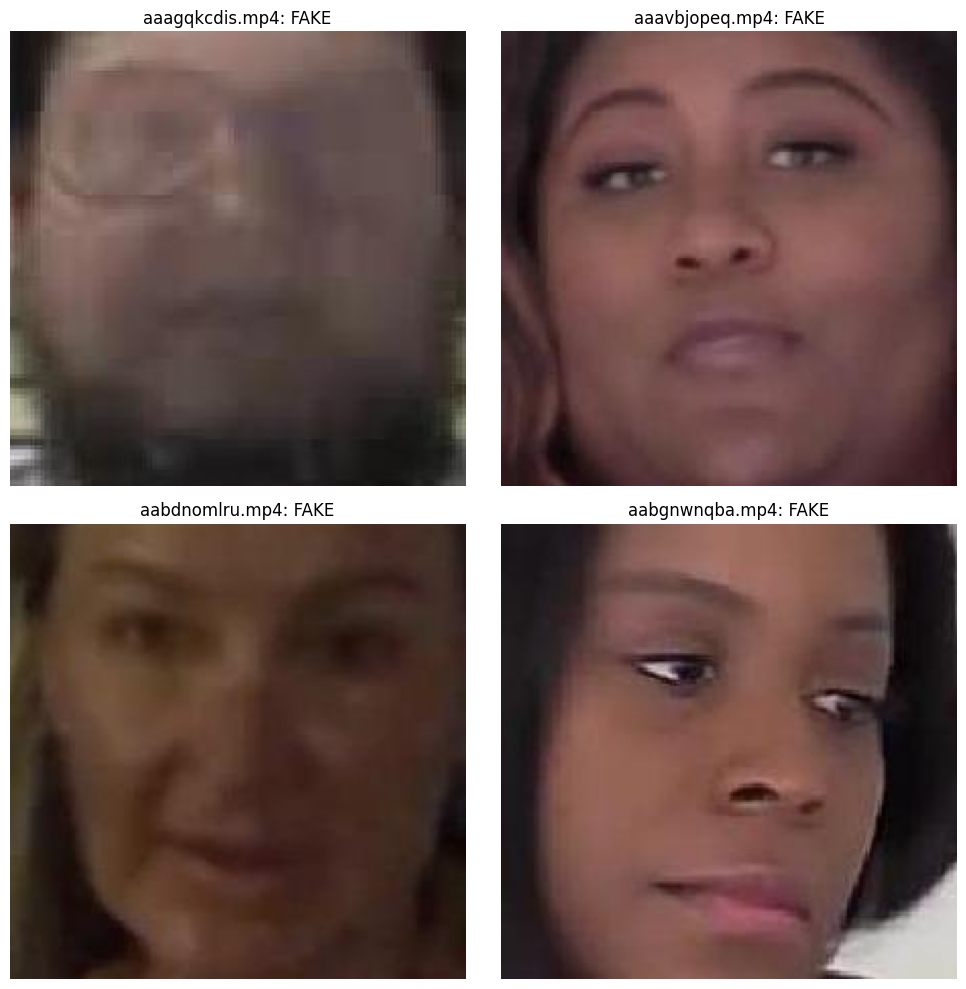

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load the CSV file
metadata = pd.read_csv('/content/deepfake-faces/metadata.csv')

# Directory containing the images
path = "/content/deepfake-faces/faces_224"

# Dictionary to hold image labels
image_labels = {
    "aaagqkcdis.mp4": None, "aaaqepxnf.mp4": None, "aaavbjopeq.mp4": None,
    "aaavfklag.mp4": None, "aabdnomlru.mp4": None, "aabdogach.mp4": None,
    "aabgnwnqba.mp4": None, "aabjfbpir.mp4": None, "aabkwhgwv.mp4": None
}

# Check each image basename against the DataFrame
for name in image_labels.keys():
    # Assuming 'videoname' is the column in the CSV that matches image names
    if name in metadata['videoname'].values:
        image_labels[name] = metadata.loc[metadata['videoname'] == name, 'label'].values[0]
    else:
        image_labels[name] = 'Label not found'

# Filter out images without valid labels
valid_images = {name: label for name, label in image_labels.items() if label != 'Label not found'}

# Determine the size of the grid based on the number of valid images
import math
grid_size = math.ceil(math.sqrt(len(valid_images)))

# Setting up the plot for a dynamic grid based on valid images
fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(10, 10))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Display each image with its label
for ax, (image_name, label) in zip(axes, valid_images.items()):
    # Load the image file
    image_path = os.path.join(path, image_name.replace('.mp4', '.jpg'))  # assuming image extension is .jpg
    if os.path.exists(image_path):
        img = Image.open(image_path)
        ax.imshow(img)
        ax.set_title(f"{image_name}: {label}")
    ax.axis('off')

# Hide any unused axes if there are fewer images than subplots
for i in range(len(valid_images), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### More exploration in terms of height, width, and aspect ratio between fake and real face images
### --> 2 goups are almost the same in terms of these characteristics.

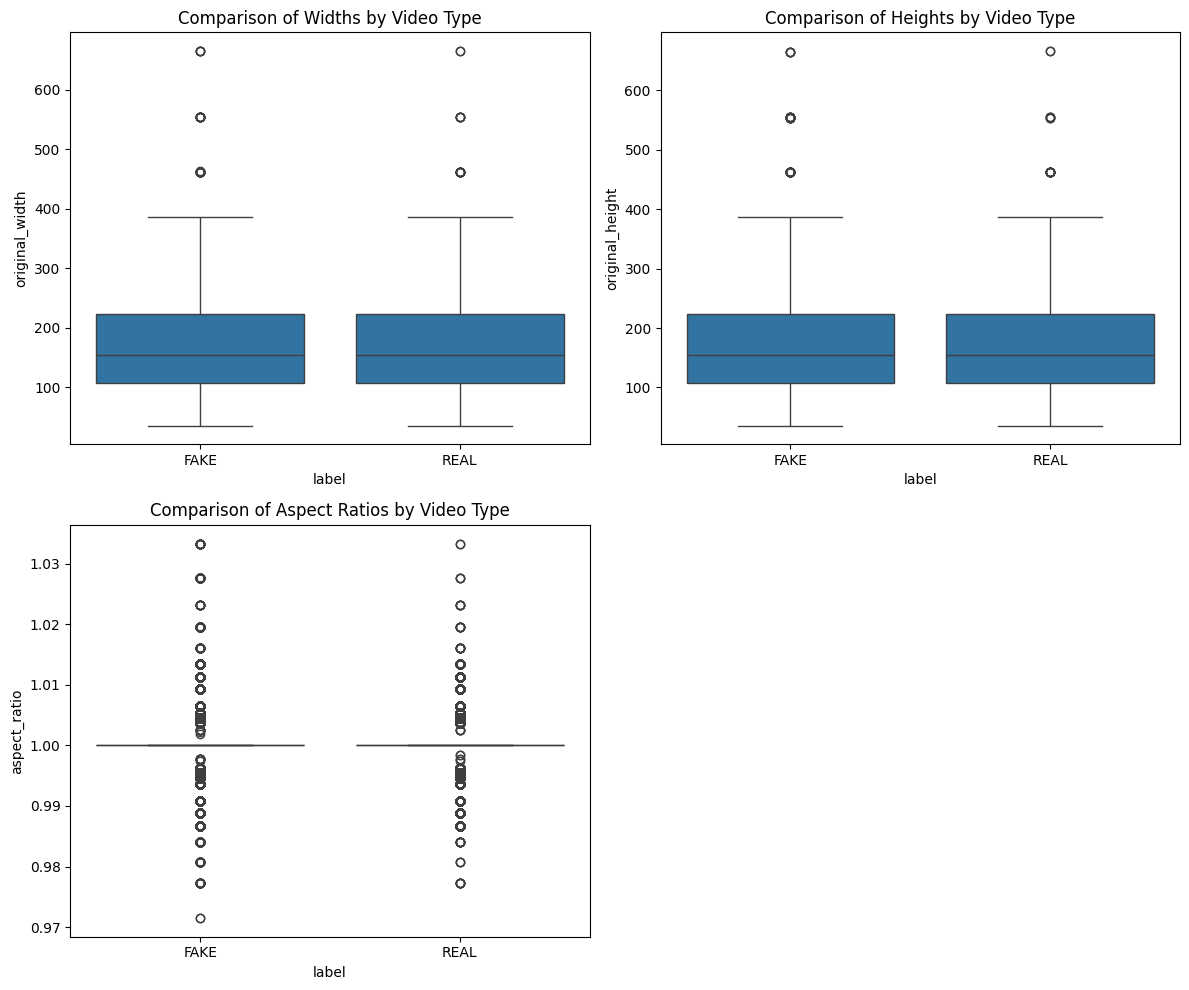

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np

# Calculate aspect ratio
deepfake['aspect_ratio'] = deepfake['original_width'] / deepfake['original_height']

# Calculate filename length
deepfake['filename_length'] = deepfake['videoname'].apply(len)

# Plotting boxplots for video dimensions and aspect ratio
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='label', y='original_width', data=deepfake)
plt.title('Comparison of Widths by Video Type')

plt.subplot(2, 2, 2)
sns.boxplot(x='label', y='original_height', data=deepfake)
plt.title('Comparison of Heights by Video Type')

plt.subplot(2, 2, 3)
sns.boxplot(x='label', y='aspect_ratio', data=deepfake)
plt.title('Comparison of Aspect Ratios by Video Type')

plt.tight_layout()
plt.show()

### Some random examples from real face images

<ipython-input-23-653ba99b4d43>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



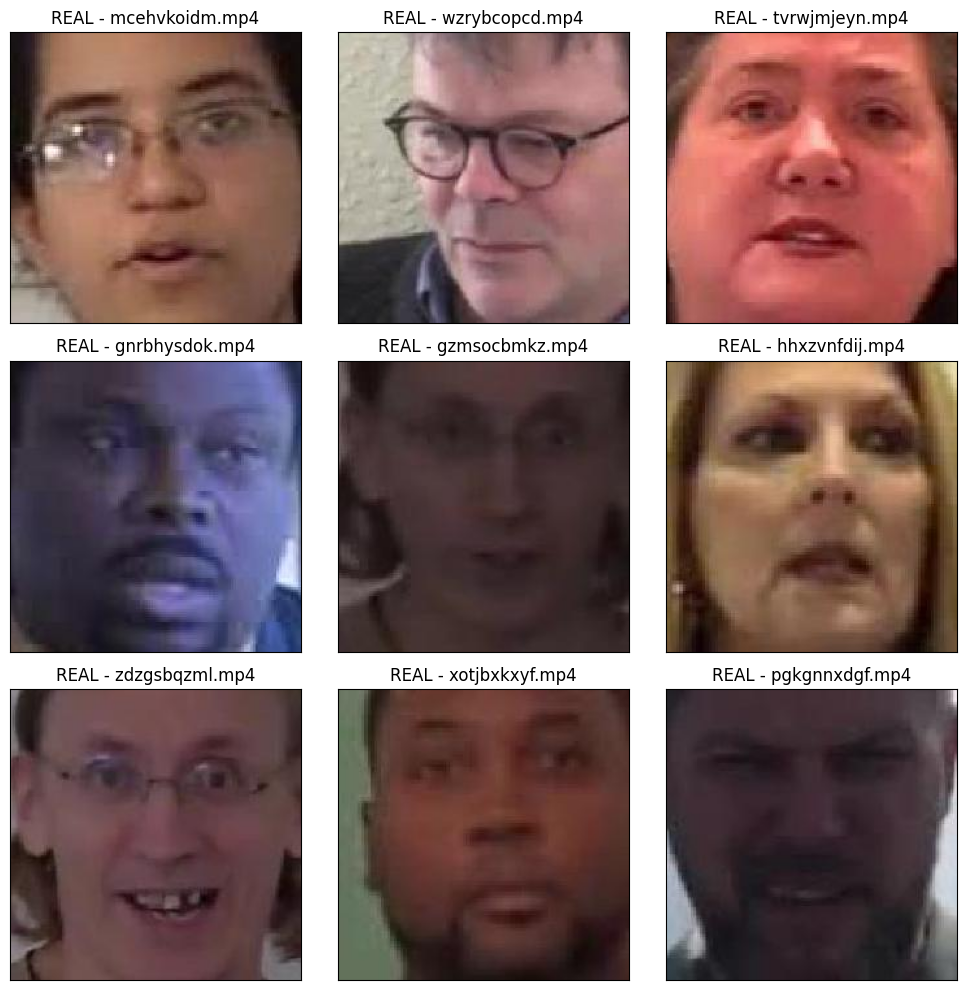

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Load the metadata and image file paths
metadata_path = '/content/deepfake-faces/metadata.csv'
images_dir = '/content/deepfake-faces/faces_224'

metadata_df = pd.read_csv(metadata_path)
real_images=metadata_df[metadata_df['label']=='REAL']

# images are named after the 'videoname' without the extension for mp4
real_images['image_fullpath'] = real_images['videoname'].apply(lambda x: os.path.join(images_dir, x.replace('.mp4', '.jpg')))

# Function to get label name
def get_label(num):
    return real_images.loc[real_images["label"] == num, "videoname"].values[0]

# Selecting 9 random indices from the dataframe
random_index = np.random.randint(0, len(real_images), 9)

# Plot configuration
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = real_images.iloc[random_index[i]]['image_fullpath']
    if os.path.exists(img_path):
        ax.imshow(plt.imread(img_path))
        ax.set_title(f"{real_images.iloc[i]['label']} - {real_images.iloc[i]['videoname']}")
    else:
        ax.imshow(np.zeros((10, 10, 3), dtype=int))  # Display blank image if not found
        ax.set_title("Image not found")

plt.tight_layout()
plt.show()


In [ ]:
real_images.head()

,videoname,original_width,original_height,label,original,image_fullpath
17,mcehvkoidm.mp4,186,185,REAL,NaN,/content/deepfake-faces/faces_224/mcehvkoidm.jpg
26,wzrybcopcd.mp4,223,223,REAL,NaN,/content/deepfake-faces/faces_224/wzrybcopcd.jpg
30,tvrwjmjeyn.mp4,107,107,REAL,NaN,/content/deepfake-faces/faces_224/tvrwjmjeyn.jpg
47,gnrbhysdok.mp4,186,186,REAL,NaN,/content/deepfake-faces/faces_224/gnrbhysdok.jpg
68,gzmsocbmkz.mp4,107,107,REAL,NaN,/content/deepfake-faces/faces_224/gzmsocbmkz.jpg


### Some randome examples from fake face images

<ipython-input-25-8542d83947a8>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



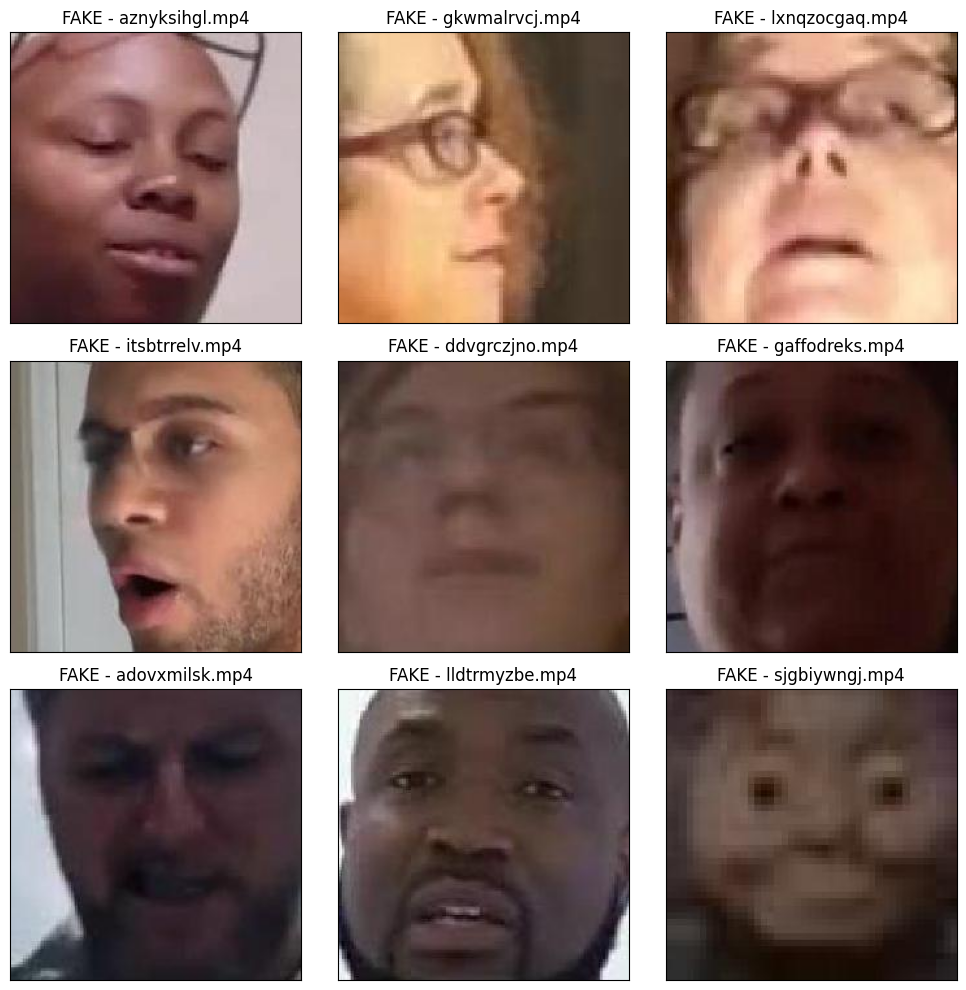

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

fake_images=metadata_df[metadata_df['label']=='FAKE']

# images are named after the 'videoname' without the extension for mp4
fake_images['image_fullpath'] = fake_images['videoname'].apply(lambda x: os.path.join(images_dir, x.replace('.mp4', '.jpg')))

# Function to get label name
def get_label(num):
    return fake_images.loc[fake_images["label"] == num, "videoname"].values[0]

# Selecting 9 random indices from the dataframe
random_index = np.random.randint(0, len(fake_images), 9)

# Plot configuration
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = fake_images.iloc[random_index[i]]['image_fullpath']
    if os.path.exists(img_path):
        ax.imshow(plt.imread(img_path))
        ax.set_title(f"{fake_images.iloc[i]['label']} - {fake_images.iloc[i]['videoname']}")
    else:
        ax.imshow(np.zeros((10, 10, 3), dtype=int))  # Display blank image if not found
        ax.set_title("Image not found")

plt.tight_layout()
plt.show()

In [ ]:
fake_images.head()

,videoname,original_width,original_height,label,original,image_fullpath
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4,/content/deepfake-faces/faces_224/aznyksihgl.jpg
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4,/content/deepfake-faces/faces_224/gkwmalrvcj.jpg
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4,/content/deepfake-faces/faces_224/lxnqzocgaq.jpg
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4,/content/deepfake-faces/faces_224/itsbtrrelv.jpg
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4,/content/deepfake-faces/faces_224/ddvgrczjno.jpg


# Shuffle and Sample Dataset


In [ ]:
len(deepfake[deepfake.label=='FAKE']),len(deepfake[deepfake.label=='REAL'])

(79341, 16293)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Replace '.mp4' with '.jpg' in the videoname column
deepfake['imgname'] = deepfake['videoname'].str.replace('.mp4', '.jpg')

# Create separate dataframes for 'REAL' and 'FAKE'
real_df = deepfake[deepfake['label'] == 'REAL']
fake_df = deepfake[deepfake['label'] == 'FAKE']

# Setup undersampler
sample_size = 10000

real_df_sample = real_df.sample(sample_size, random_state=43)
fake_df_sample = fake_df.sample(sample_size, random_state=43)

# Combine and shuffle
sample_meta = pd.concat([real_df_sample, fake_df_sample]).sample(frac=1, random_state=43)


train_set, test_set = train_test_split(sample_meta, test_size=0.2, random_state=43, stratify=sample_meta['label'])
train_set, val_set = train_test_split(train_set, test_size=0.3, random_state=43, stratify=train_set['label'])

In [ ]:
len(sample_meta[sample_meta.label=='FAKE']),len(sample_meta[sample_meta.label=='REAL'])

(10000, 10000)

In [ ]:
sample_meta.head()

,videoname,original_width,original_height,label,original,aspect_ratio,filename_length,imgname
38503,wrzuojwklk.mp4,267,267,REAL,NaN,1.000000,14,wrzuojwklk.jpg
58739,ynaxskshcg.mp4,267,268,FAKE,wugkgprala.mp4,0.996269,14,ynaxskshcg.jpg
35224,sxrxjtqxkv.mp4,186,186,REAL,NaN,1.000000,14,sxrxjtqxkv.jpg
89328,idevihnoiu.mp4,129,129,REAL,NaN,1.000000,14,idevihnoiu.jpg
44151,agcoyyzeju.mp4,223,222,REAL,NaN,1.004505,14,agcoyyzeju.jpg


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Prepare image data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Setup train, validation, and test generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_set,
    directory='/content/deepfake-faces/faces_224/',
    x_col='imgname',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_set,
    directory='/content/deepfake-faces/faces_224/',
    x_col='imgname',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_set,
    directory='/content/deepfake-faces/faces_224/',
    x_col='imgname',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for test set
)

Found 11200 validated image filenames belonging to 2 classes.
Found 4800 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [ ]:
import tensorflow as tf
from functools import partial

def build_custom_cnn(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

custom_cnn_model = build_custom_cnn((224, 224, 3))

In [ ]:
custom_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
def build_transfer_learning_model():
    # Load the base model from Xception pre-trained on ImageNet, without the top layer
    base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False)

    # Add global average pooling layer as the new top layer of the model
    avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

    # Add a dense layer with sigmoid activation for binary classification
    output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)

    # Define the model specifying inputs and outputs
    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    # Freeze the layers of the base model to prevent them from being updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with SGD optimizer and binary crossentropy loss
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model

# Create the model by calling the function
transfer_learning_model = build_transfer_learning_model()

In [ ]:
transfer_learning_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]'

In [ ]:
# Train Custom CNN Model
history_custom_cnn = custom_cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10
350/350 [==============================] - 159s 453ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
350/350 [==============================] - 158s 451ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
350/350 [==============================] - 158s 453ms/step - loss: 0.6932 - accuracy: 0.4974 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
350/350 [==============================] - 158s 452ms/step - loss: 0.6939 - accuracy: 0.5030 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/10
350/350 [==============================] - 159s 454ms/step - loss: 0.6934 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
350/350 [==============================] - 163s 465ms/step - loss: 0.6935 - accuracy: 0.4937 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
350/350 [==============================] - 159s 456ms/step - loss: 0.6933 - accuracy: 0.4927 - val_loss: 0.6932 -

In [ ]:
# Train Transfer Learning Model
history_transfer_learning_model = transfer_learning_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10
350/350 [==============================] - 168s 472ms/step - loss: 1.1410 - accuracy: 0.5513 - val_loss: 0.9132 - val_accuracy: 0.5819
Epoch 2/10
350/350 [==============================] - 165s 472ms/step - loss: 1.0762 - accuracy: 0.5655 - val_loss: 0.9052 - val_accuracy: 0.5910
Epoch 3/10
350/350 [==============================] - 167s 477ms/step - loss: 1.2126 - accuracy: 0.5662 - val_loss: 1.0578 - val_accuracy: 0.5844
Epoch 4/10
350/350 [==============================] - 165s 471ms/step - loss: 1.0274 - accuracy: 0.5833 - val_loss: 1.5720 - val_accuracy: 0.5331
Epoch 5/10
350/350 [==============================] - 165s 472ms/step - loss: 1.1449 - accuracy: 0.5850 - val_loss: 0.7929 - val_accuracy: 0.6112
Epoch 6/10
350/350 [==============================] - 164s 470ms/step - loss: 1.0298 - accuracy: 0.5854 - val_loss: 0.8180 - val_accuracy: 0.5979
Epoch 7/10
350/350 [==============================] - 164s 470ms/step - loss: 1.0407 - accuracy: 0.5886 - val_loss: 0.8778 -

In [ ]:
def transfer_learning_model_v2():
    # Load the base model from Xception pre-trained on ImageNet, without the top layer
    base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False)

    # Add global average pooling layer as the new top layer of the model
    avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

    # Add a dense layer with sigmoid activation for binary classification
    output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)

    # Define the model specifying inputs and outputs
    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    # Freeze the layers of the base model initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze certain layers for more fine-tuning
    for layer in base_model.layers[56:]:
        layer.trainable = True

    # Use a slower learning rate for fine-tuning
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model

# Create the model by calling the function
transfer_learning_model_v2 = transfer_learning_model_v2()

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
transfer_learning_model.summary()

NameError: name 'transfer_learning_model' is not defined

In [ ]:
# Train Transfer Learning Model
history_transfer_learning_model_v2 = transfer_learning_model_v2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10
350/350 [==============================] - 178s 480ms/step - loss: 0.6365 - accuracy: 0.6323 - val_loss: 0.5633 - val_accuracy: 0.7017
Epoch 2/10
350/350 [==============================] - 168s 479ms/step - loss: 0.5332 - accuracy: 0.7292 - val_loss: 0.5813 - val_accuracy: 0.7000
Epoch 3/10
350/350 [==============================] - 165s 472ms/step - loss: 0.4685 - accuracy: 0.7734 - val_loss: 0.4534 - val_accuracy: 0.7904
Epoch 4/10
350/350 [==============================] - 167s 477ms/step - loss: 0.4201 - accuracy: 0.8052 - val_loss: 0.5495 - val_accuracy: 0.7558
Epoch 5/10
350/350 [==============================] - 166s 474ms/step - loss: 0.3943 - accuracy: 0.8169 - val_loss: 0.4425 - val_accuracy: 0.7933
Epoch 6/10
350/350 [==============================] - 166s 473ms/step - loss: 0.3550 - accuracy: 0.8414 - val_loss: 0.5092 - val_accuracy: 0.7690
Epoch 7/10
350/350 [==============================] - 169s 483ms/step - loss: 0.3288 - accuracy: 0.8542 - val_loss: 0.4291 -

125/125 [==============================] - 40s 318ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2000
           1       0.33      0.00      0.00      2000

    accuracy                           0.50      4000
   macro avg       0.42      0.50      0.33      4000
weighted avg       0.42      0.50      0.33      4000

[[1998    2]
 [1999    1]]


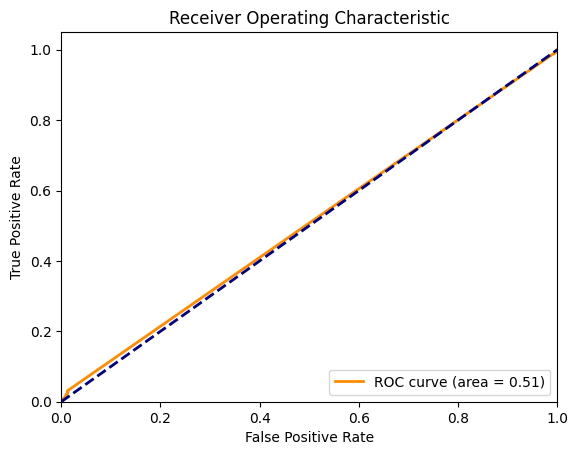

125/125 [==============================] - 40s 320ms/step
              precision    recall  f1-score   support

           0       0.53      0.85      0.65      2000
           1       0.61      0.24      0.35      2000

    accuracy                           0.55      4000
   macro avg       0.57      0.55      0.50      4000
weighted avg       0.57      0.55      0.50      4000

[[1696  304]
 [1515  485]]


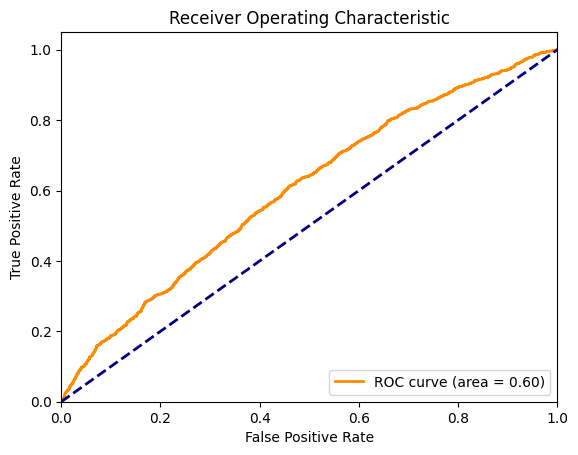

125/125 [==============================] - 40s 322ms/step
              precision    recall  f1-score   support

           0       0.93      0.57      0.70      2000
           1       0.69      0.96      0.80      2000

    accuracy                           0.76      4000
   macro avg       0.81      0.76      0.75      4000
weighted avg       0.81      0.76      0.75      4000

[[1133  867]
 [  83 1917]]


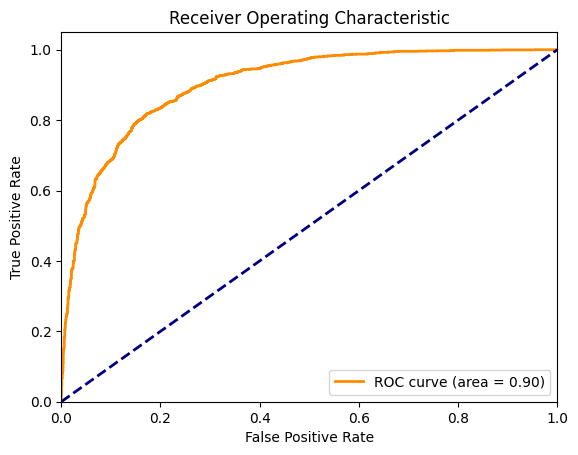

In [ ]:
def evaluate_model(model, generator):
    # Predictions
    predictions = model.predict(generator)
    y_true = generator.classes
    y_pred = (predictions > 0.5).astype(int)

    # Print classification report
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate both models
evaluate_model(custom_cnn_model, test_generator)
evaluate_model(transfer_learning_model, test_generator)
evaluate_model(transfer_learning_model_v2, test_generator)

In [ ]:
custom_cnn_model.save('models/custom_cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
transfer_learning_model.save('models/transfer_model_v1.h5')

In [ ]:
transfer_learning_model_v2.save('models/transfer_model_v2.h5')